In [1]:
import os
import pandas as pd
import numpy as np
import time
import pickle
import random
random.seed(0)

import matplotlib.pyplot as plt

import lightgbm as lgb

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [3]:
from process import type_score

In [4]:
train_data = '20190721_dist_ang_ori_bond_cos_train_{}.pickle'
trained_models = '20190721_champs_models_lgb_{}.pickle'
pred_train_name = '20190721_predict_train.pickle'
pred_train_temp = 'predict_train_temp_{}.pickle'
pred_val_name = '20190721_predict_val.pickle'
pred_val_temp = 'predict_val_temp_{}.pickle'

In [5]:
df = pd.DataFrame()
bond_types = ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
for b in bond_types:
    df_bond = pd.read_pickle(OUTPUT + train_data.format(b)).fillna(0)
    df = pd.concat([df, df_bond], axis=0)

In [6]:
df.shape

(4658147, 221)

In [7]:
mols = df['molecule_name'].unique()
num = len(mols)
num_train = int(num * 0.95)
pickup = random.sample(range(num), num)
pick_train = pickup[:num_train]
pick_val = pickup[num_train:]

In [8]:
df_train = df[df['molecule_name'].isin(mols[pick_train])]
df_val = df[df['molecule_name'].isin(mols[pick_val])]

In [9]:
rounds = 300000
num_seed = 1
# bond_types = ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
bond_types = ['3JHN', '3JHC','1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH']

---------- 3JHN ----------
seed No.0, bond type 3JHN
best iteration: 162435
single model score valid: -2.25
elapsed_time:2748.26[sec]
mean-ensemble score train: -3.96
mean-ensemble score valid: -2.25


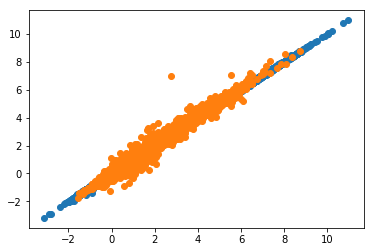

/home/ryoji/Documents/git/kaggle/ml/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ryoji/Documents/git/kaggle/ml/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


---------- 3JHC ----------
seed No.0, bond type 3JHC


In [ ]:
models = []
scores = []
start0 = time.time()

for i, b in enumerate(bond_types):
    print('-'*10, b, '-'*10)
    
    models_b = []
    y_train_pred_b =[]
    y_val_pred_b =[]
    
    df_train_b = df_train.query('type == "{}"'.format(b))
    y_train = df_train_b['scalar_coupling_constant'].values
    X_train = df_train_b[df_train.columns[6:]].values

    df_val_b = df_val.query('type == "{}"'.format(b))
    y_val = df_val_b['scalar_coupling_constant'].values
    X_val = df_val_b[df_val.columns[6:]].values

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        
    for s in range(num_seed):
        print('seed No.{}, bond type {}'.format(s, b))
        start = time.time()

        params = {
                'task' : 'train',
                'boosting_type' : 'gbdt',
                'objective' : 'regression',
                'metric' : {'l1'},
                'num_leaves' : 63,
                'learning_rate' : 0.0025,
                'feature_fraction' : 0.7,
                'bagging_fraction' : 0.7,
                'bagging_freq': 5,
            'seed':s
        }

        gbm = lgb.train(params,
                lgb_train,
                num_boost_round=rounds,
                verbose_eval=0,
                valid_sets=lgb_eval,
                early_stopping_rounds=20)

        models_b.append(gbm)
        
        y_train_pred_single = gbm.predict(X_train, num_iteration=gbm.best_iteration)
        y_train_pred_b.append(y_train_pred_single)
        
        y_val_pred_single = gbm.predict(X_val, num_iteration=gbm.best_iteration)
        y_val_pred_b.append(y_val_pred_single)
        
        print('best iteration: %.f' % gbm.best_iteration)
        print('single model score valid: %.2f' % type_score(y_val, y_val_pred_single))
        elapsed_time = time.time() - start
        print ("elapsed_time:%.2f" % elapsed_time + "[sec]")
        
    y_train_pred = np.array(y_train_pred_b).mean(axis=0)
    y_val_pred = np.array(y_val_pred_b).mean(axis=0)
    
    score_train = type_score(y_train_pred, y_train)
    score_val = type_score(y_val_pred, y_val)
    
    print('mean-ensemble score train: %.2f' % score_train)
    print('mean-ensemble score valid: %.2f' % score_val)
    
    plt.scatter(y_train_pred, y_train)
    plt.scatter(y_val_pred, y_val)
    plt.show()
    
    df_train_b['predict'] = y_train_pred
    df_train_b.to_pickle(OUTPUT +  pred_train_temp.format(b))

    df_val_b['predict'] = y_val_pred
    df_val_b.to_pickle(OUTPUT + pred_val_temp.format(b))
    
    with open(OUTPUT + trained_models.format(b), 'wb') as f:
        pickle.dump(models_b, f)

    scores.append(score_val)
elapsed_time = time.time() - start0
print ("total elapsed_time:%.2f" % (elapsed_time/3600) + "[hours]")


In [ ]:
print('type score:', scores)
print('total score:', np.array(scores).mean())

# bond_types = ['3JHN', '3JHC','1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH']
# type score: [-2.213330811075121, -1.3581258350105094, -0.7845050130296711, -2.1655013094988513, -1.4024121799402647, -1.9751865470643377, -1.499394936229838, -2.1188348800106724]
# total score: -1.689661438982408

In [ ]:
df_train_predict = pd.DataFrame()
df_val_predict = pd.DataFrame()

for b in bond_types:
    df_train_predict_b = pd.read_pickle(OUTPUT + pred_train_temp.format(b))
    df_train_predict = pd.concat([df_train_predict, df_train_predict_b], axis=0)
    
    df_val_predict_b = pd.read_pickle(OUTPUT + pred_val_temp.format(b))
    df_val_predict = pd.concat([df_val_predict, df_val_predict_b], axis=0)

df_train_predict.to_pickle(OUTPUT + pred_train_name)
df_val_predict.to_pickle(OUTPUT + pred_val_name)